<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/checkpoint_review_JH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re

FIG_NO = count(1)

def _expand_title(title_prefix: str) -> str:
    """
    Parse tokens like "<TL y1 + y2 → y2>" or "[TL y1 + y2 → y2]" and
    convert to a readable figure title, e.g., "y1 transfer learned with y2"
    (if target == finetune) or "y1 transfer learned with y2 to predict y3".
    Falls back to the raw prefix (with brackets removed) if parsing fails.
    """
    # extract inside <> or []
    m = re.search(r'[\[<]\s*(.*?)\s*[\]>]', title_prefix or "")
    core = (m.group(1) if m else title_prefix or "").strip()

    # try to parse "TL A + B → T"
    m2 = re.match(r'^TL\s+(.+?)\s*\+\s*(.+?)\s*→\s*(.+)$', core)
    if m2:
        A, B, T = [s.strip() for s in m2.groups()]
        if T == B:
            return f"{A} transfer learned with {B}"
        else:
            return f"{A} transfer learned with {B} to predict {T}"

    # otherwise just remove brackets and return
    return core

def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  fig_no=None, caption=None, y_lim=None):
    if fig_no is None:
        fig_no = next(FIG_NO)

    mse = (y_true - y_pred) ** 2

    cmap_y = "Greys"
    m_true, m_pred = "o", "^"
    edge = "black"

    fig = plt.figure(figsize=(16, 5))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1, 1, 1])

    # (a) True — 3D
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.scatter(Kv, Lv, y_true, c=y_true, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_true, edgecolor=edge, linewidth=0.3)
    ax1.set_title("(a) True Y")
    ax1.set_xlabel("K"); ax1.set_ylabel("L"); ax1.set_zlabel("Y")
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    if y_lim is not None:
        ax1.set_zlim(*y_lim)

    # (b) Predicted — 3D
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    ax2.scatter(Kv, Lv, y_pred, c=y_pred, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_pred, edgecolor=edge, linewidth=0.3)
    ax2.set_title("(b) Predicted Ŷ")
    ax2.set_xlabel("K"); ax2.set_ylabel("L"); ax2.set_zlabel("Ŷ")
    ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    if y_lim is not None:
        ax2.set_zlim(*y_lim)

    # (c) MSE — 2D: x = varying axis (K or L), y = MSE
    ax3 = fig.add_subplot(gs[0, 2])
    if np.nanstd(Lv) < 1e-9:
        x_vals, x_label = np.ravel(Kv), "K"
    elif np.nanstd(Kv) < 1e-9:
        x_vals, x_label = np.ravel(Lv), "L"
    else:
        x_vals, x_label = np.ravel(Kv), "K"
    ax3.scatter(x_vals, np.ravel(mse), c="dimgray", s=14,
                marker="s", edgecolor=edge, linewidth=0.3)
    ax3.set_title("(c) MSE (Y−Ŷ)^2")
    ax3.set_xlabel(x_label); ax3.set_ylabel("MSE")
    ax3.set_xlim(0, 1); ax3.set_ylim(0, 1)

    # Figure title from expanded prefix
    pretty = _expand_title(title_prefix)
    cap = f"Figure {fig_no}. {pretty}"
    if caption:
        cap += f" — {caption}"
    fig.suptitle(cap, fontsize=18, y=0.98)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0.35)
    ax1.text2D(0.02, 0.92, "○ True,  △ Pred,  ■ MSE",
               transform=ax1.transAxes, fontsize=9)

    plt.show()


## Data Generation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

### Build Original Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.09 KB)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 356 (1.39 KB)

### Build TL Models

In [4]:
# TL Model 1 - Train on y1 data -> Transfer Learning to y2 data (last 2 layers)
model_tf_y2 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y2.add(layer)

model_tf_y2.add(Dense(8, activation="relu"))
model_tf_y2.add(Dense(1))
model_tf_y2.compile(optimizer="adam", loss="mse")

model_tf_y2.fit(X_K, y2, verbose=0, epochs=100, batch_size=32)

# TL Model 2 - Train on y1 data -> Transfer Learning to y3 data (last 2 layers)
model_tf_y3 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y3.add(layer)

model_tf_y3.add(Dense(8, activation="relu"))
model_tf_y3.add(Dense(1))
model_tf_y3.compile(optimizer="adam", loss="mse")

model_tf_y3.fit(X_L, y3, verbose=0, epochs=100, batch_size=32)

# Run

## Showing effective results of Transfer Learning

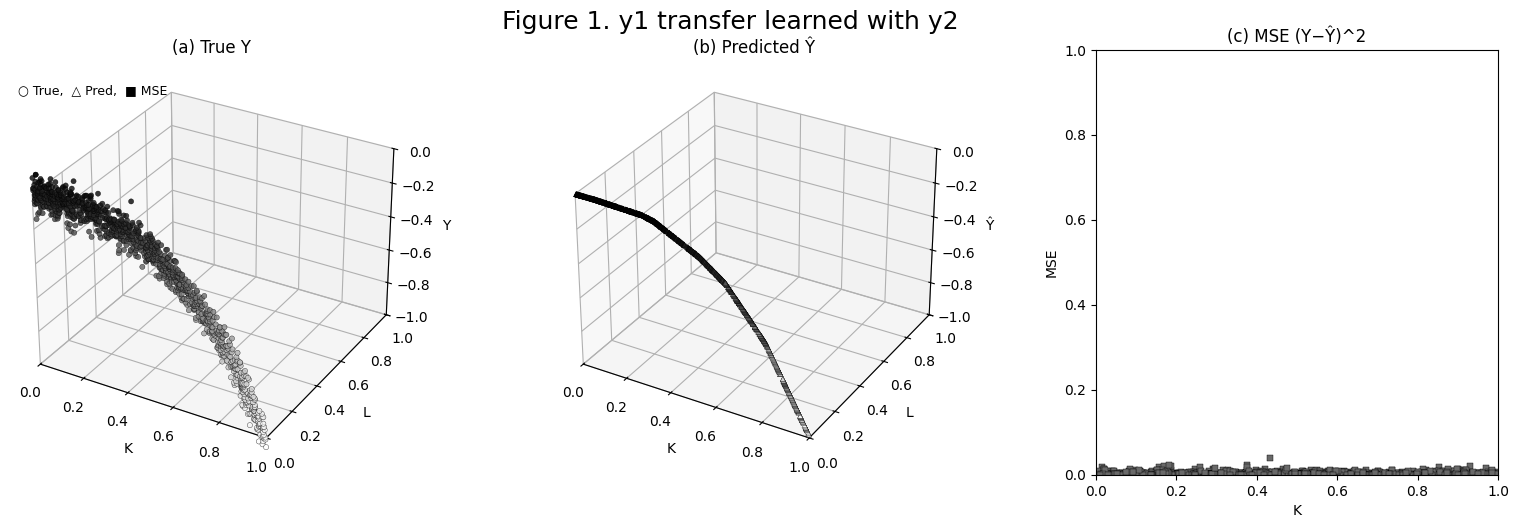

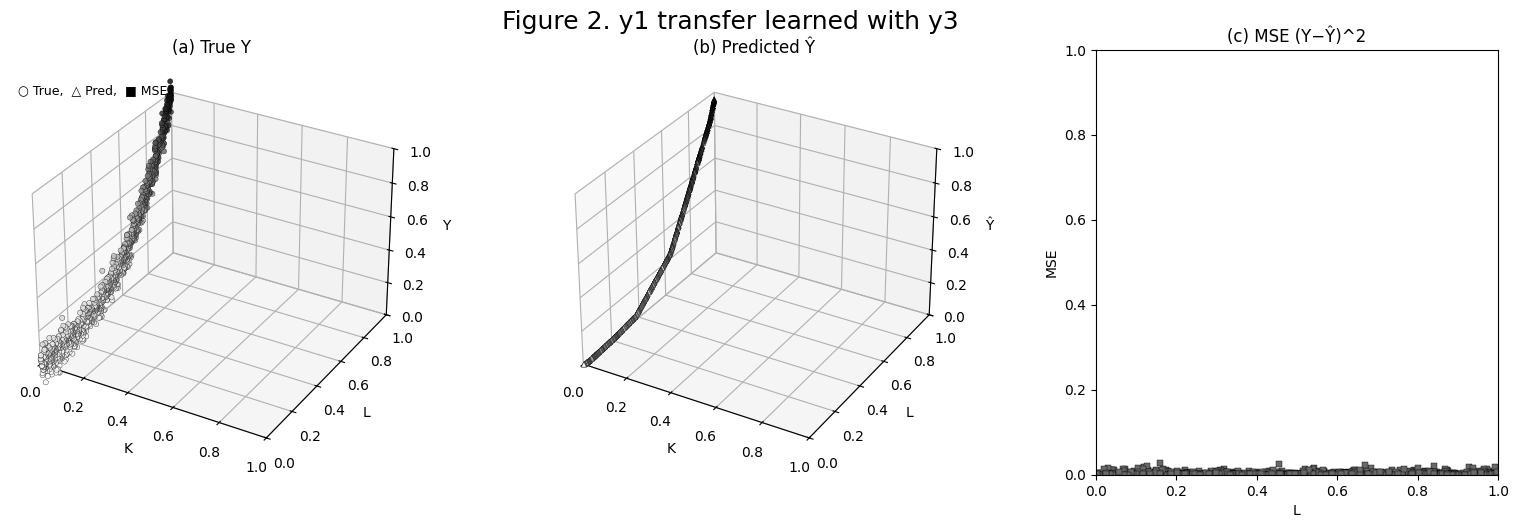

In [5]:
y2_pred_tf = model_tf_y2.predict(X_K, verbose=0)
y3_pred_tf = model_tf_y3.predict(X_L, verbose=0)
draw_triptych("[TL y1 + y2 → y2]", K, L0,  y2, y2_pred_tf, y_lim = (-1,0))
draw_triptych("[TL y1 + y3 → y3]", K0, L, y3, y3_pred_tf, y_lim = (0,1))


## Original Model Evaluated on untrained data - high MSE

[Base y1 → y2] MSE = 0.565549
[Base y1 → y3] MSE = 0.207177


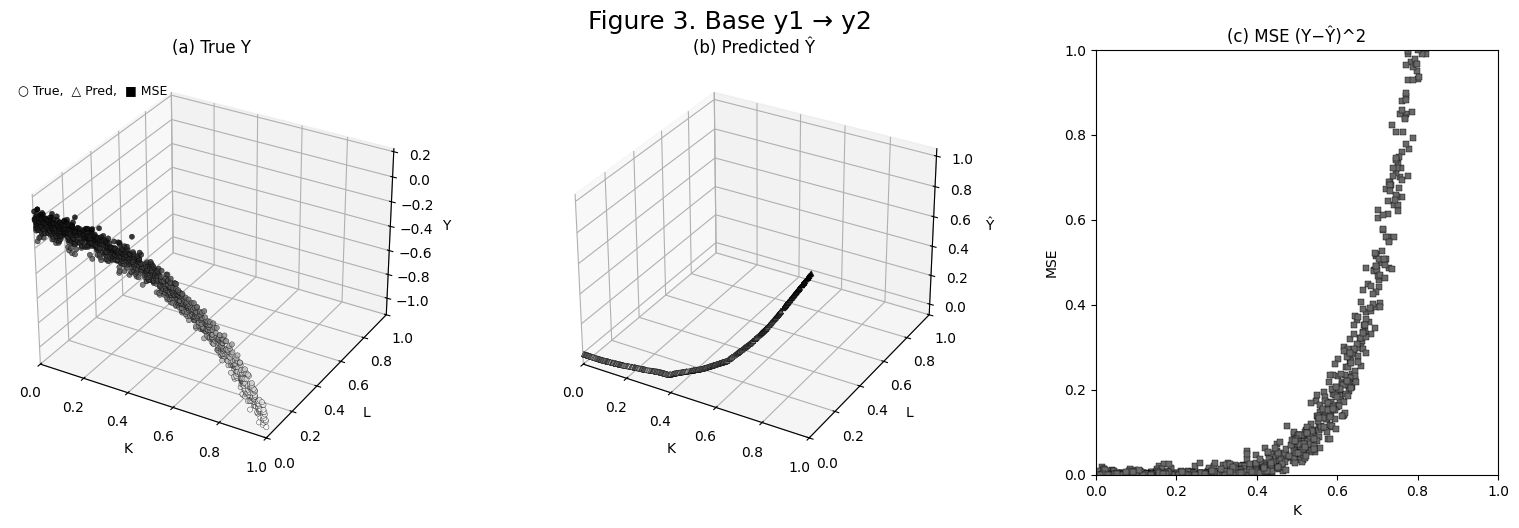

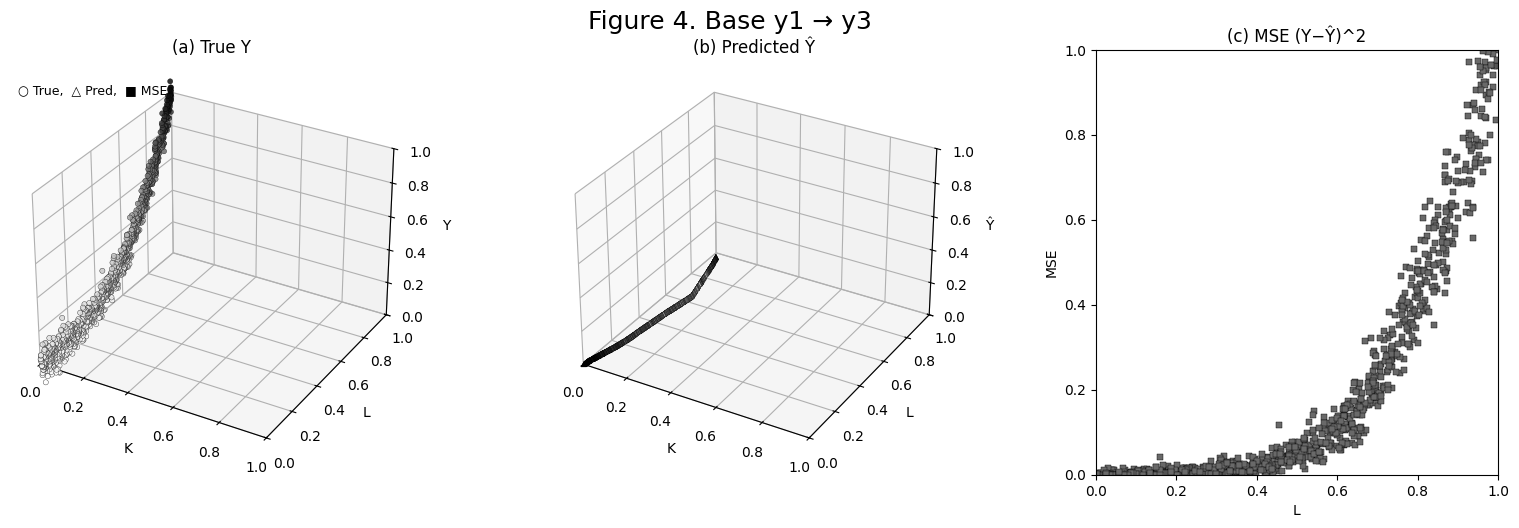

In [6]:
# Baseline (no transfer): use original `model` trained on y1
from sklearn.metrics import mean_squared_error

# Predict y2 (K^2) and y3 (L^3) with the base model
y2_pred_base = model.predict(X_K, verbose=0)
y3_pred_base = model.predict(X_L, verbose=0)

# Compute MSEs for reference
mse_y2_base = mean_squared_error(y2, y2_pred_base)
mse_y3_base = mean_squared_error(y3, y3_pred_base)
print(f"[Base y1 → y2] MSE = {mse_y2_base:.6f}")
print(f"[Base y1 → y3] MSE = {mse_y3_base:.6f}")

# Visualize: (a) True Y, (b) Pred Ŷ, (c) 2D MSE plot (x = varying axis, y = MSE)
# y2 task: vary K (L=0)
draw_triptych("[Base y1 → y2]", K, L0, y2, y2_pred_base)

# y3 task: vary L (K=0)
draw_triptych("[Base y1 → y3]", K0, L, y3, y3_pred_base, y_lim=(0, 1))


## Show 10 Trials and Mean (model trained on K-intensive predicting L-intensive data)

[Trial 1/10] training on y1 ...
[Trial 1/10] MSE (y1 → y3) = 0.072214
[Trial 2/10] training on y1 ...
[Trial 2/10] MSE (y1 → y3) = 0.054437
[Trial 3/10] training on y1 ...
[Trial 3/10] MSE (y1 → y3) = 0.041734
[Trial 4/10] training on y1 ...
[Trial 4/10] MSE (y1 → y3) = 0.039746
[Trial 5/10] training on y1 ...
[Trial 5/10] MSE (y1 → y3) = 0.063634
[Trial 6/10] training on y1 ...
[Trial 6/10] MSE (y1 → y3) = 0.146987
[Trial 7/10] training on y1 ...
[Trial 7/10] MSE (y1 → y3) = 0.043708
[Trial 8/10] training on y1 ...
[Trial 8/10] MSE (y1 → y3) = 0.251549
[Trial 9/10] training on y1 ...
[Trial 9/10] MSE (y1 → y3) = 0.029609
[Trial 10/10] training on y1 ...
[Trial 10/10] MSE (y1 → y3) = 0.014213
[Trial 1/10] plotting ...


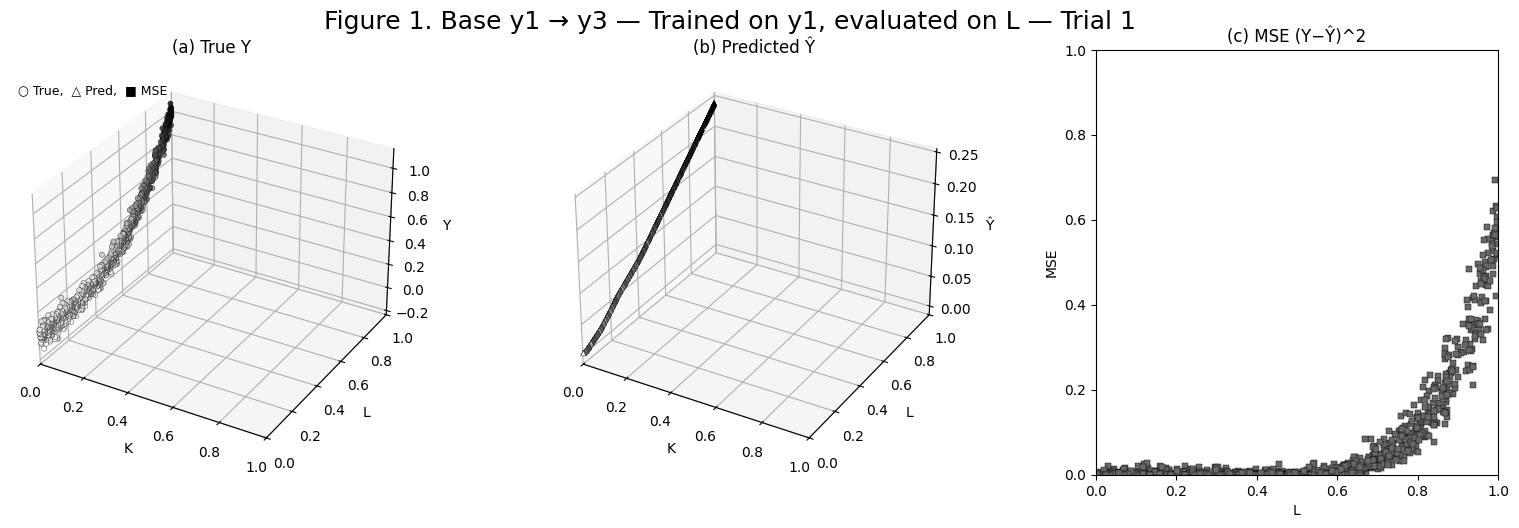

[Trial 2/10] plotting ...


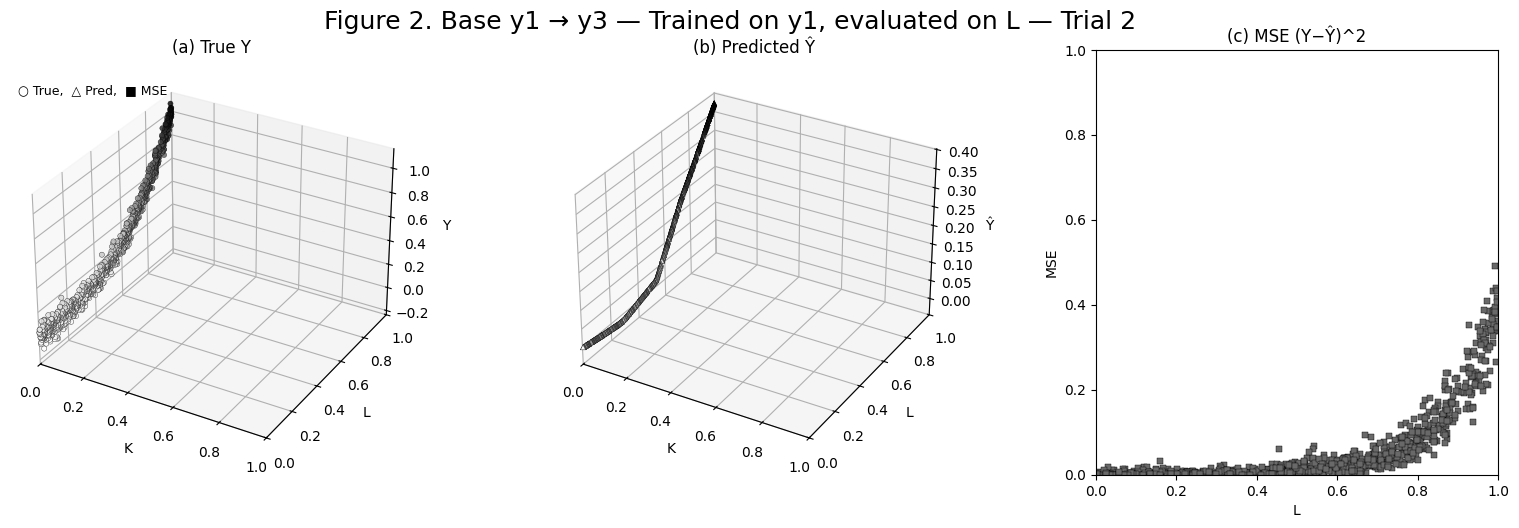

[Trial 3/10] plotting ...


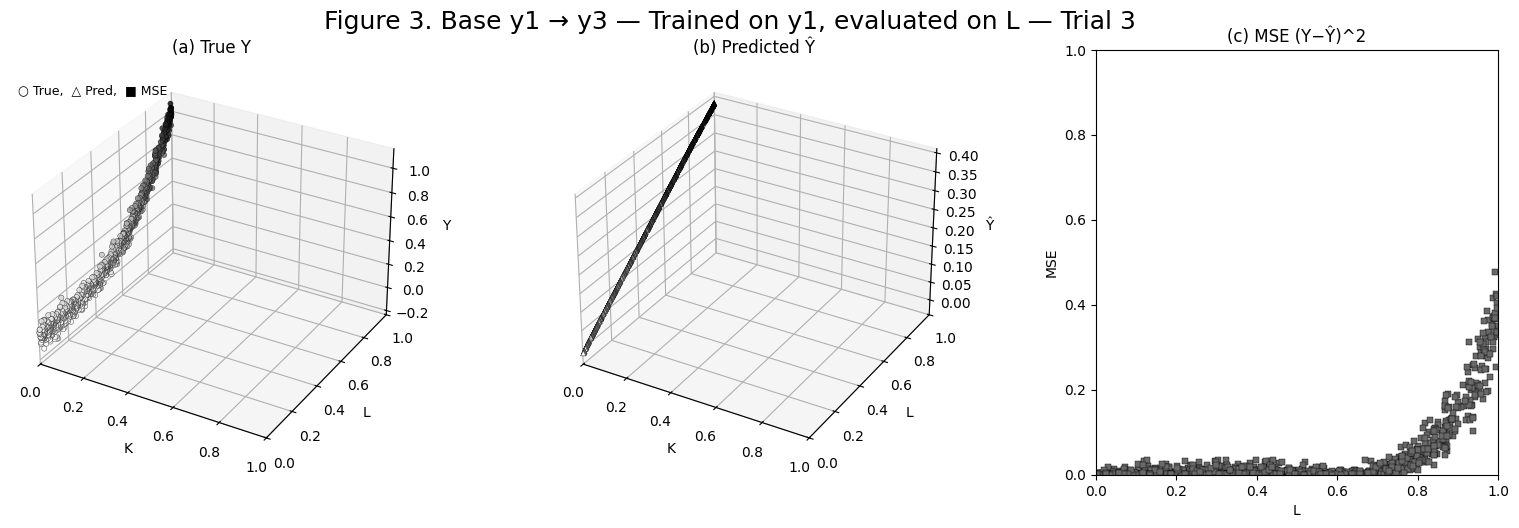

[Trial 4/10] plotting ...


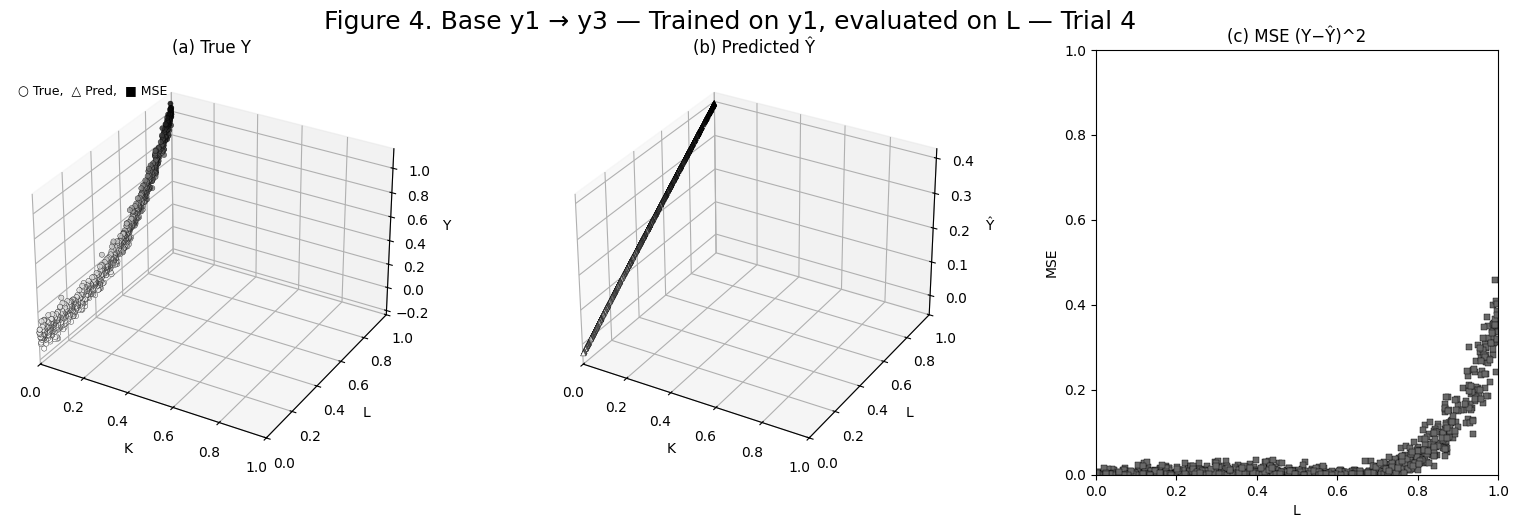

[Trial 5/10] plotting ...


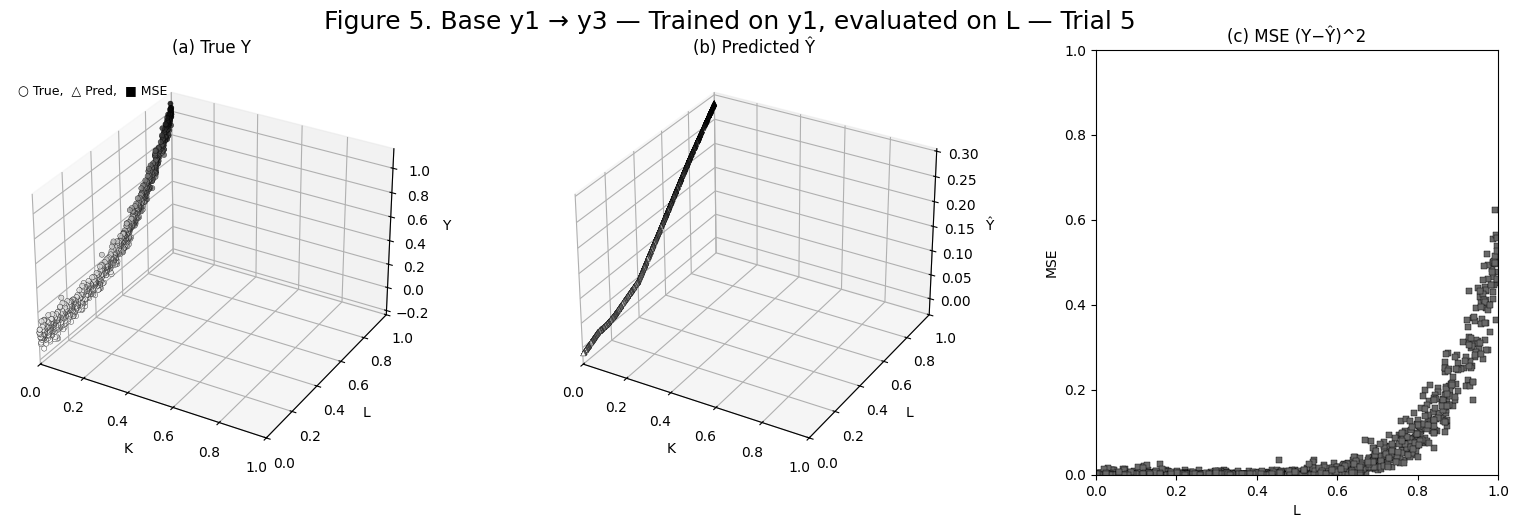

[Trial 6/10] plotting ...


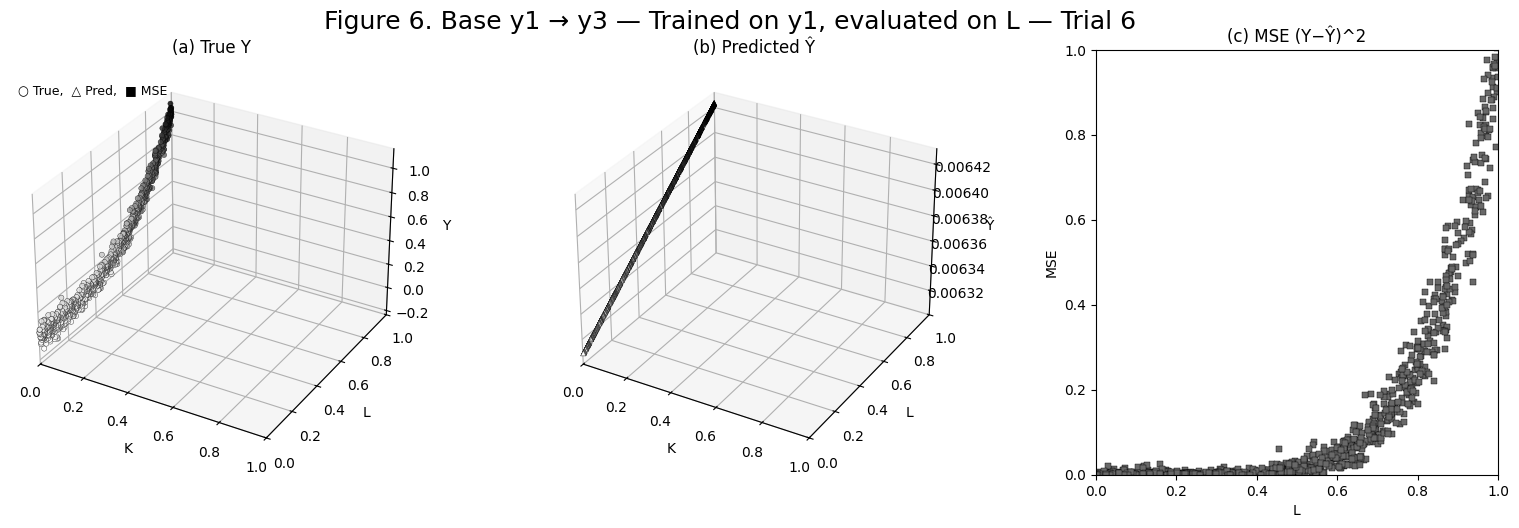

[Trial 7/10] plotting ...


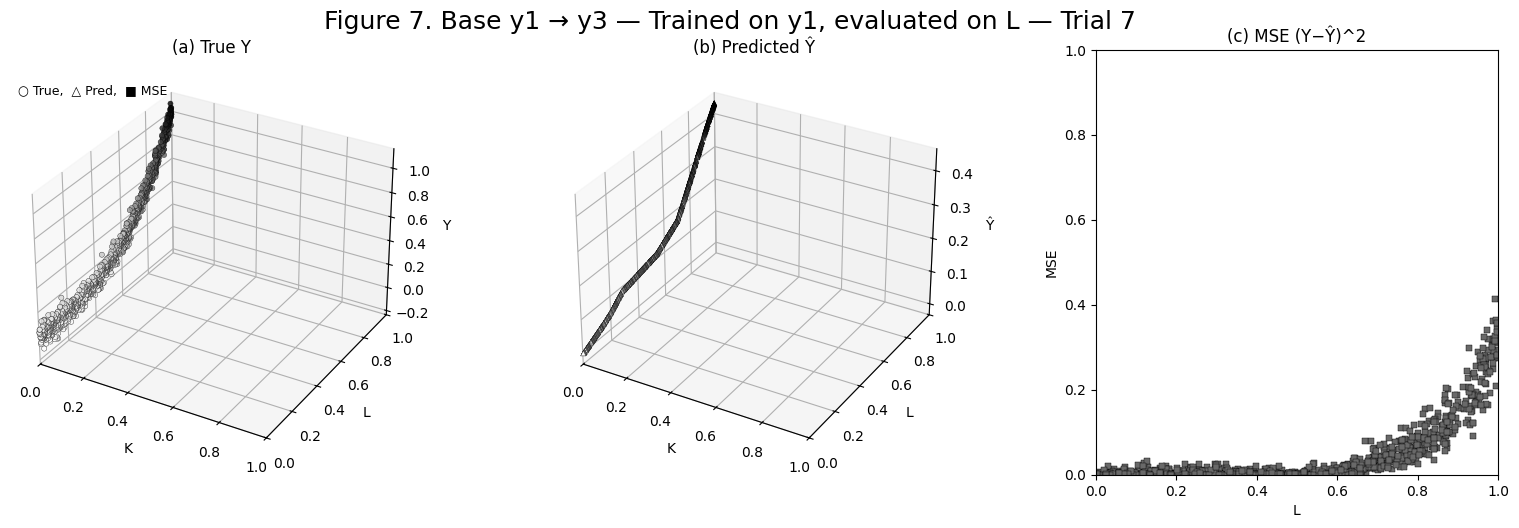

[Trial 8/10] plotting ...


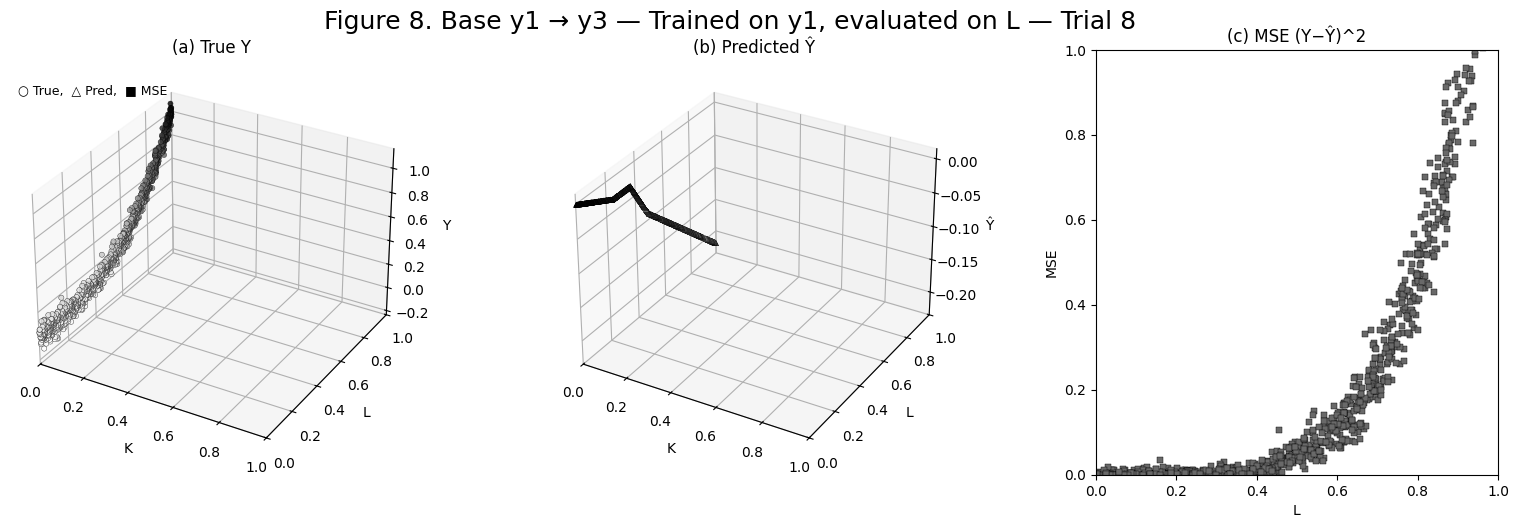

[Trial 9/10] plotting ...


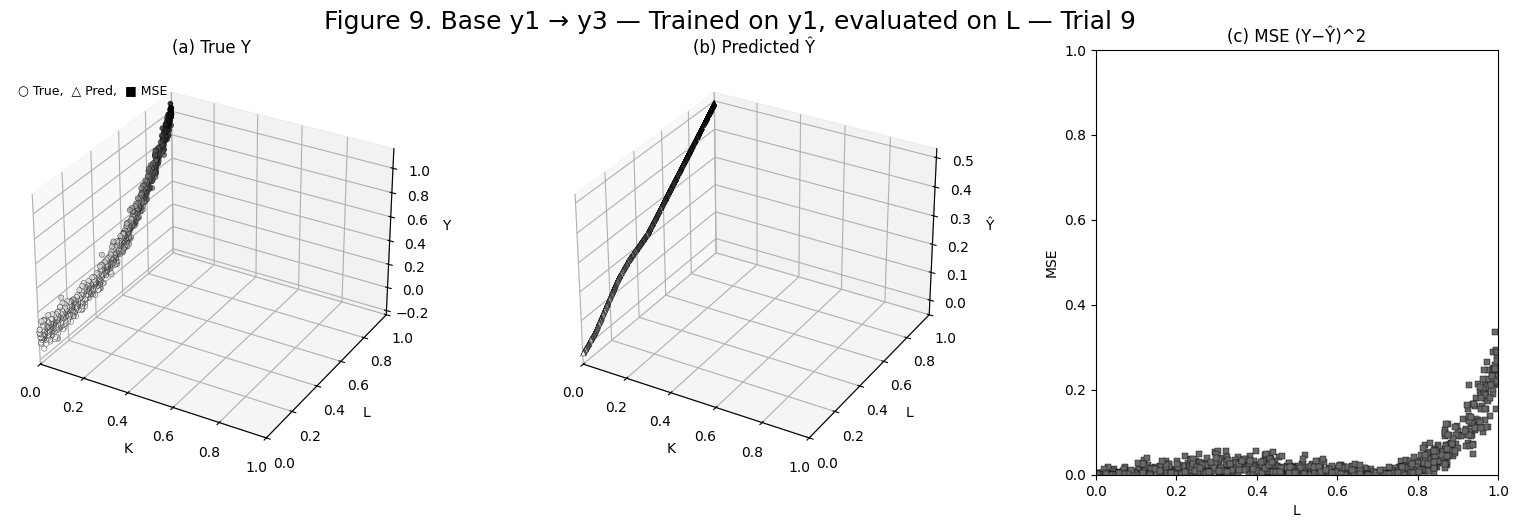

[Trial 10/10] plotting ...


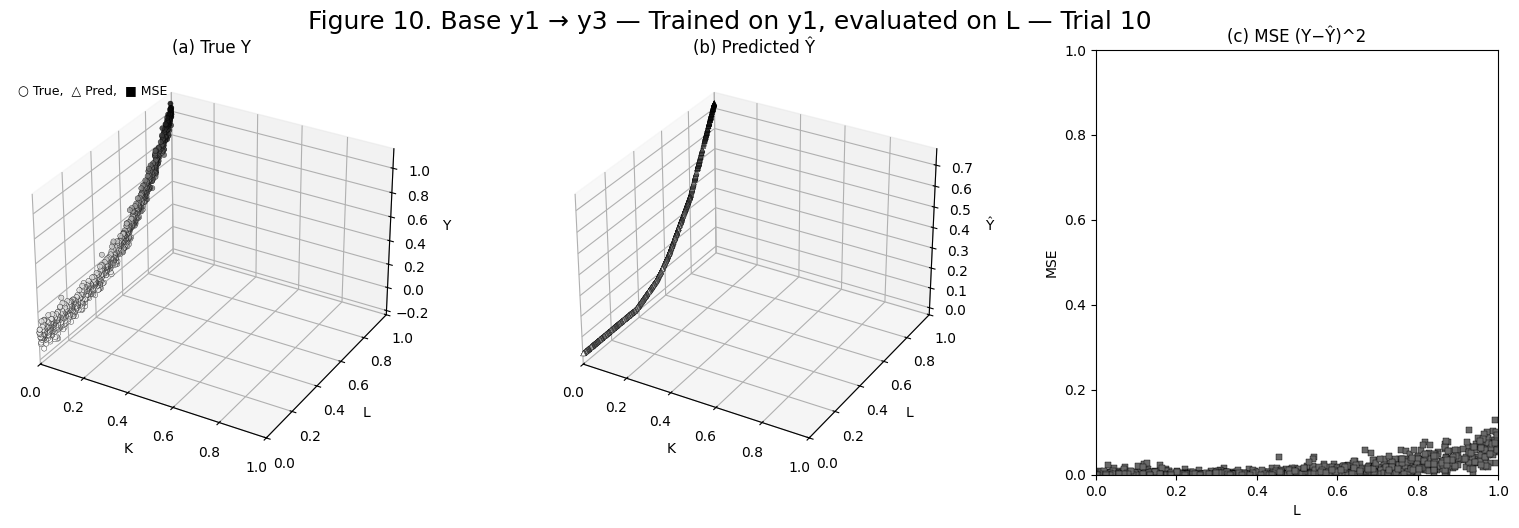


Mean MSE over 10 trials (y1 → y3): 0.060859


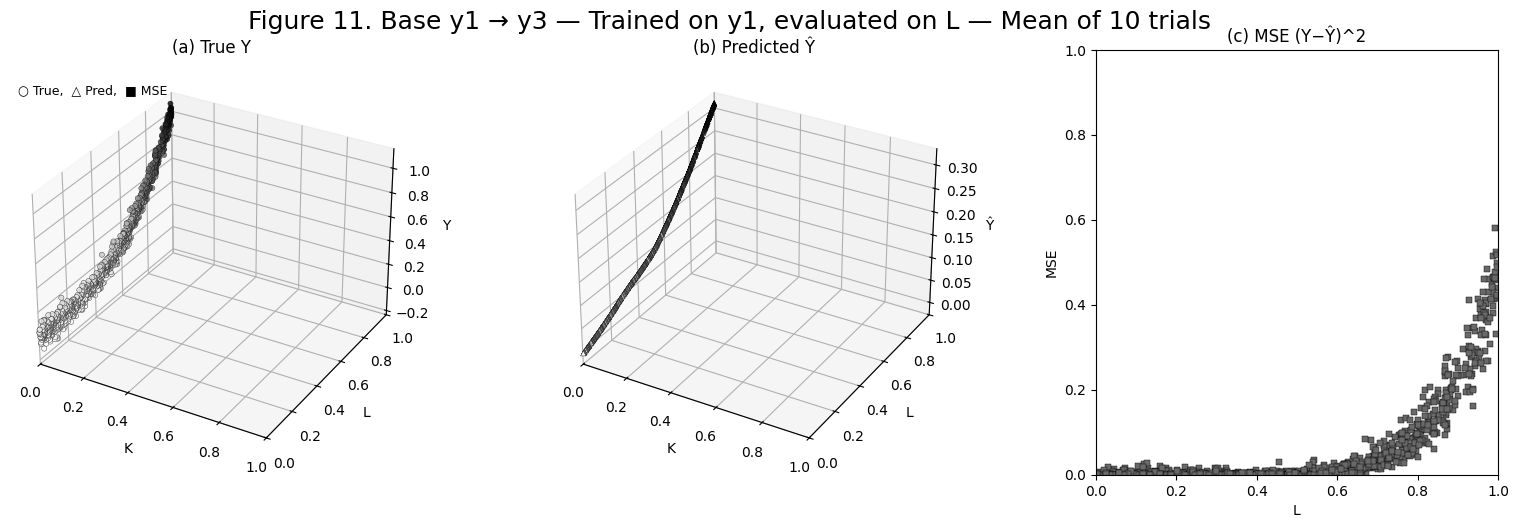

In [7]:
# ---------- Train 10 independent models on y1, evaluate on L (y3) ----------
from sklearn.metrics import mean_squared_error
import numpy as np

n_trials = 10
L_preds = []
mses = []

# 1) Train 10 models (random init), each on y1, then predict y3
for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] training on y1 ...")
    m = build_model()
    m.fit(X_K, y1, epochs=50, batch_size=32, verbose=0)   # train ONLY on y1
    L_pred_t = m.predict(X_L, verbose=0).ravel()           # evaluate on L (y3 task)
    L_preds.append(L_pred_t)

    mse_t = mean_squared_error(y3.ravel(), L_pred_t)
    mses.append(mse_t)
    print(f"[Trial {t+1}/{n_trials}] MSE (y1 → y3) = {mse_t:.6f}")

# 2) Prepare 1D views for plotting
L_preds = np.vstack(L_preds)              # shape (10, N)
L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()

# 3) Plot each trial
for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] plotting ...")
    draw_triptych(
        title_prefix="[Base y1 → y3]",
        Kv=K0_1d, Lv=L_1d,
        y_true=L_true_1d, y_pred=L_preds[t],
        fig_no=t+1,
        caption=f"Trained on y1, evaluated on L — Trial {t+1}"
        # , y_lim=(-0.1, 1.1)  # uncomment if you want a fixed z-range for (a)(b)
    )

# 4) Plot mean prediction across 10 trials
L_pred_mean = L_preds.mean(axis=0)
mse_mean = mean_squared_error(L_true_1d, L_pred_mean)
print(f"\nMean MSE over {n_trials} trials (y1 → y3): {mse_mean:.6f}")

draw_triptych(
    title_prefix="[Base y1 → y3]",
    Kv=K0_1d, Lv=L_1d,
    y_true=L_true_1d, y_pred=L_pred_mean,
    fig_no=n_trials+1,
    caption=f"Trained on y1, evaluated on L — Mean of {n_trials} trials"
    # , y_lim=(-0.1, 1.1)
)


## Transfer Learning with 1 layer open

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# --- TL: last-layer-only (y2) ---
model_tf_1layer_y2 = Sequential(name="model_tf_1layer_y2")

# add pretrained backbone layers EXCEPT the original final output layer
for lyr in model.layers[:-1]:   # exclude model.layers[-1]
    lyr.trainable = False       # freeze backbone
    model_tf_1layer_y2.add(lyr)

# add a NEW trainable output head (only this layer is trainable)
model_tf_1layer_y2.add(Dense(1, activation="linear", name="head_1layer_y2"))

model_tf_1layer_y2.compile(optimizer="adam", loss="mse")
model_tf_1layer_y2.fit(X_K, y2, epochs=100, batch_size=32, verbose=0)


# --- TL: last-layer-only (y3) ---
model_tf_1layer_y3 = Sequential(name="model_tf_1layer_y3")

for lyr in model.layers[:-1]:
    lyr.trainable = False
    model_tf_1layer_y3.add(lyr)

model_tf_1layer_y3.add(Dense(1, activation="linear", name="head_1layer_y3"))

model_tf_1layer_y3.compile(optimizer="adam", loss="mse")
model_tf_1layer_y3.fit(X_L, y3, epochs=100, batch_size=32, verbose=0)

# (optional) quick check
print("\n[Trainable flags: model_tf_1layer_y2]")
for lyr in model_tf_1layer_y2.layers:
    print(f"{lyr.name:28s} trainable={lyr.trainable}")



[Trainable flags: model_tf_1layer_y2]
input_relu                   trainable=False
dense                        trainable=False
dense_1                      trainable=False
dense_2                      trainable=False
head_1layer_y2               trainable=True


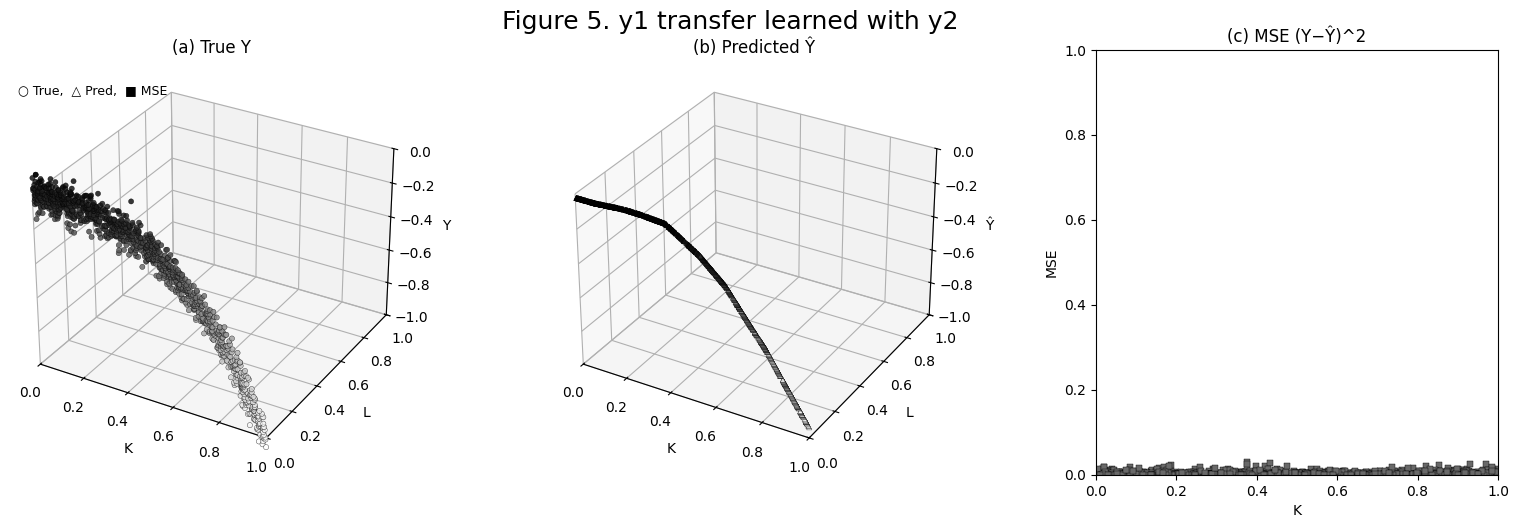

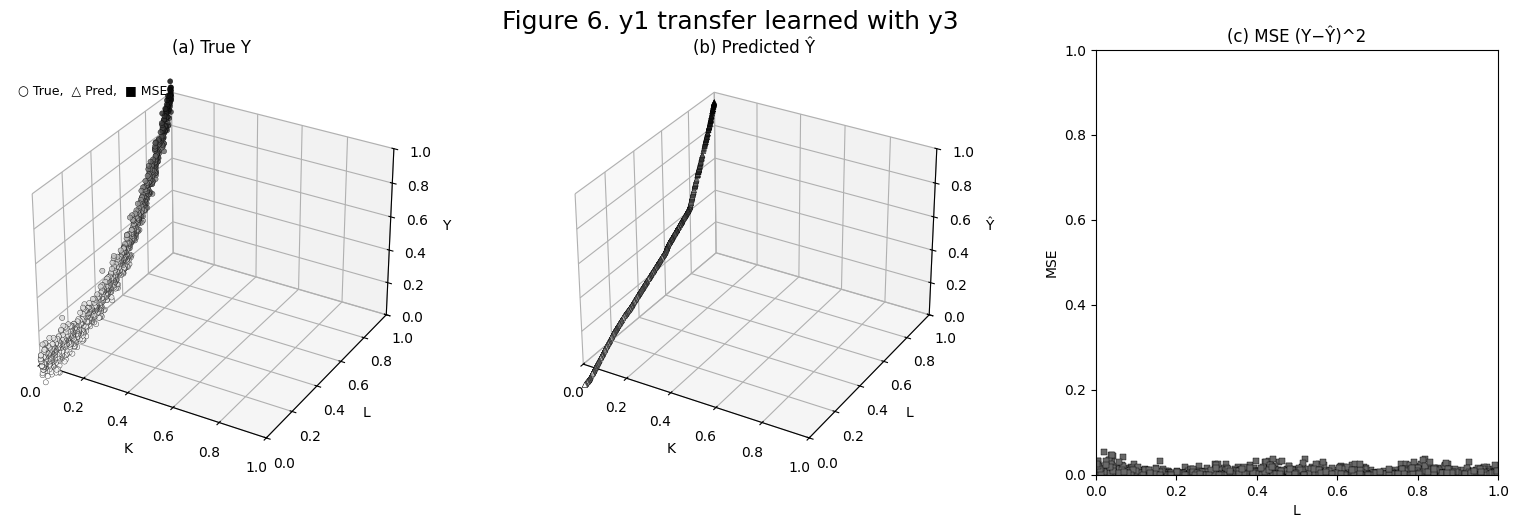

In [9]:
y2_pred_tf = model_tf_1layer_y2.predict(X_K, verbose=0)
y3_pred_tf = model_tf_1layer_y3.predict(X_L, verbose=0)

draw_triptych("[TL y1 + y2 → y2]", K, L0,  y2, y2_pred_tf, y_lim = (-1,0))
draw_triptych("[TL y1 + y3 → y3]", K0, L, y3, y3_pred_tf, y_lim = (0,1))


Underfitted than 2 layers open as expected, but matches the trend of the data.